/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_79793/3932993159.py:64: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  Lt = fsolve(F, Lt_guess, xtol=1E-6, maxfev=1000, factor=1, epsfcn=1E-6)
/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_79793/3932993159.py:64: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Lt = fsolve(F, Lt_guess, xtol=1E-6, maxfev=1000, factor=1, epsfcn=1E-6)


5.658109997308536e-06 7.408943950421531e-06
3.1374789117855073e-06 -0.00011283335958828028
-3.1071271331395423e-06 -0.00021813595527245266
5.005012554404331e-07 -0.00019247605537729695
-2.677055517819049e-06 -0.00019281274275960436
-3.7560180676798893e-06 -0.00017187455529099616
0.0030109883113677016 -0.00354027651858152
0.002719258718793194 -0.003222879751288949
-0.029475513853263968 -0.020481327411736944
-0.0319071382317464 -0.02282269787644206
-0.032651586220601825 -0.02391319256071342
1.5306755862809496e-11 -7.2405414996978834e-12
-0.03045934126545069 -0.03142569733023104
-0.021369446937036907 -0.020907459664178035
-0.03600246322914746 -0.03411170199546444
-0.0306392292256098 -0.030564490241314274
-0.006951916826936189 -0.0066798099748475726
-0.007156262907588862 -0.006699223062474273
2.5650814805544542e-11 3.5483144200654237e-12
-0.0024026680036036696 -0.0020414148806307056
-7.968070647734748e-13 -1.1032841307212493e-15
-0.0075371602701665985 -0.006658284260440905
-0.0253991611032

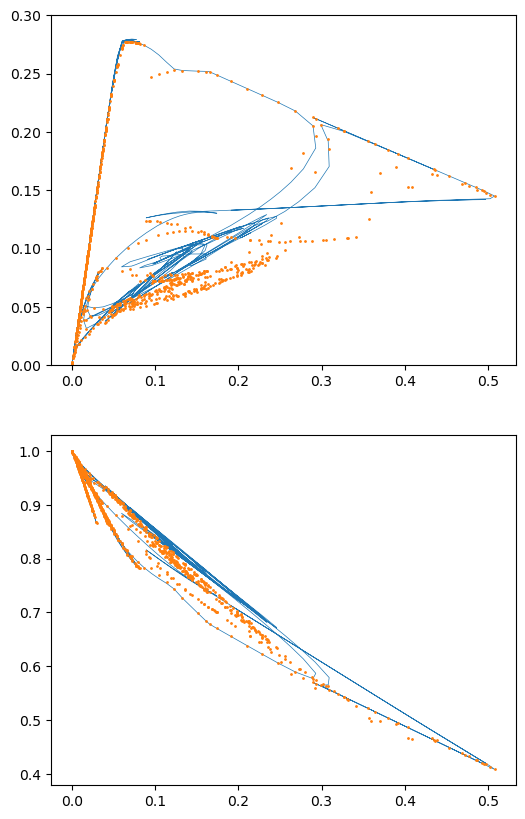

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.optimize import fsolve

#####################

nf = 82
nL = 16
nt = 6

fgrid = np.linspace(0,1,nf)            # table coordinates
Lgrid = np.arange(nL, dtype=np.float64)
tgrid = np.arange(nt, dtype=np.float64)

c = np.zeros((nf, nL, nt))
h = np.zeros((nf, nL, nt))
T = np.zeros((nf, nL, nt))

for iL in range(nL):
    for it in range(nt):
        fname = "flm_" + str(iL).zfill(2) + '_' + str(it).zfill(2) + ".dat"
        data = np.loadtxt(fname)

        ii = interp1d(data[:,1], data[:,4])       # mixf, c
        c[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,3])       # mixf, h
        h[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,2])       # mixf, T
        T[:,iL, it] = ii(fgrid)

#####################

hmax = np.max(h)
hmin = np.min(h)
h = (h-hmin)/(hmax-hmin)

#####################

cI = RGI((fgrid, Lgrid, tgrid), c, bounds_error=False, fill_value=None)      # call as cI([fvalue, Lvalue, tvalue])
hI = RGI((fgrid, Lgrid, tgrid), h, bounds_error=False, fill_value=None)      
TI = RGI((fgrid, Lgrid, tgrid), T, bounds_error=False, fill_value=None)

#####################

def Ftest(L, t, h, c):
    F0 = hI([f, L, t])[0] - h
    F1 = cI([f, L, t])[0] - c
    return np.array([F0, F1])

def get_Lt(f, h, c, Lt_guess=np.array([1.0,2.0])):

    def F(Lt):
        L = Lt[0]
        t = Lt[1]
        F0 = hI([f, L, t])[0] - h
        F1 = cI([f, L, t])[0] - c
        return np.array([F0, F1])

    Lt = fsolve(F, Lt_guess, xtol=1E-6, maxfev=1000, factor=1, epsfcn=1E-6)
    return Lt[0], Lt[1]

#####################

#L, t = get_Lt(0.05045, -7.3E5, 0.0517)
#print(L,t)

#####################

#odt = np.loadtxt('data_adia/dmp_00016.dat')    # 16, 23
odt = np.loadtxt('data_radi/dmp_00012.dat')     # 9, 10, 12
xodt = odt[:,0]
fodt = odt[:,8]
Todt = odt[:,7]
hodt = (odt[:, 28]-hmin)/(hmax-hmin)
codt = odt[:, 11] + odt[:,16] + odt[:,22] + odt[:,23]

nodt = len(fodt)
TT = np.zeros(nodt)
cc = np.zeros(nodt)
hh = np.zeros(nodt)
Lt_guess = np.array([1.0, 2.0])
for i in range(nodt):
    L, t = get_Lt(fodt[i], hodt[i], codt[i], Lt_guess)
    TT[i] = TI([fodt[i], L, t])[0]
    cc[i] = cI([fodt[i], L, t])[0]
    hh[i] = hI([fodt[i], L, t])[0]
    #TT[i] = TI([fodt[i], L, 0])[0]               # forces adiabatic 
    #Lt_guess = np.array([L, t])
    #if i%20==0: print(L,t, cc[i], hh[i])
    #if i%20==0: print(np.abs((codt[i]-cc[i])/codt[i]))
    if i%20==0: print(hI([fodt[i],L,t])[0]-hodt[i], cI([fodt[i],L,t])[0]-codt[i])

#------------------------

plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
plt.plot(fodt, codt, '-', lw=0.5)
plt.plot(fodt, cc, 'o', ms=1, lw=0.5)
plt.ylim([0,0.3])

plt.subplot(2,1,2)
plt.plot(fodt, hodt, '-', lw=0.5)
plt.plot(fodt, hh, 'o', ms=1, lw=0.5)

In [ ]:
?fsolve